In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out_conv(d1)


In [8]:
model = UNet(num_classes=3)
model.load_state_dict(torch.load("iris_pupil_unet.pth"))
model.eval().to("cuda")


UNet(
  (enc1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1

In [9]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def extract_circle_from_mask(binary_mask):
    ys, xs = np.where(binary_mask > 0)
    if len(xs) < 5:
        return None
    points = np.column_stack([xs, ys])
    center, radius = cv2.minEnclosingCircle(points.astype(np.float32))
    return (int(center[0]), int(center[1])), int(radius)

def segment_and_draw_circles(model, image_path, input_size=(256, 256), show=True):
    # === Step 1: Load and resize image
    full_res_img = cv2.imread(image_path)
    full_res_img = cv2.cvtColor(full_res_img, cv2.COLOR_BGR2RGB)
    full_res_vis = full_res_img.copy()

    H_full, W_full = full_res_img.shape[:2]

    resized_img = cv2.resize(full_res_img, input_size)
    img_tensor = torch.from_numpy(resized_img).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    img_tensor = img_tensor.to('cuda')

    # === Step 2: Run model
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor)
        pred_mask = logits.argmax(dim=1)[0].cpu().numpy()

    # === Step 3: Resize prediction back to full-res
    full_mask = cv2.resize(pred_mask.astype(np.uint8), (W_full, H_full), interpolation=cv2.INTER_NEAREST)
    pupil_mask = (full_mask == 2).astype(np.uint8)
    iris_mask  = (full_mask == 1).astype(np.uint8)

    # === Step 4: Extract circles from full-res mask
    pupil_circle = extract_circle_from_mask(pupil_mask)
    iris_circle  = extract_circle_from_mask(iris_mask)

    # === Step 5: Draw on full-res image
    if pupil_circle:
        cv2.circle(full_res_vis, pupil_circle[0], pupil_circle[1], (255, 255, 0), 2)
    if iris_circle:
        cv2.circle(full_res_vis, iris_circle[0], iris_circle[1], (0, 255, 255), 2)

    # === Step 6: Optional visualization
    if show:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        axes[0].imshow(full_res_img)
        axes[0].set_title("Original Image")

        axes[1].imshow(full_mask, cmap='jet', vmin=0, vmax=2)
        axes[1].set_title("Predicted Mask")

        axes[2].imshow(full_res_vis)
        axes[2].set_title("Overlay: Circles on Full Image")

        for ax in axes:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    return pupil_circle, iris_circle


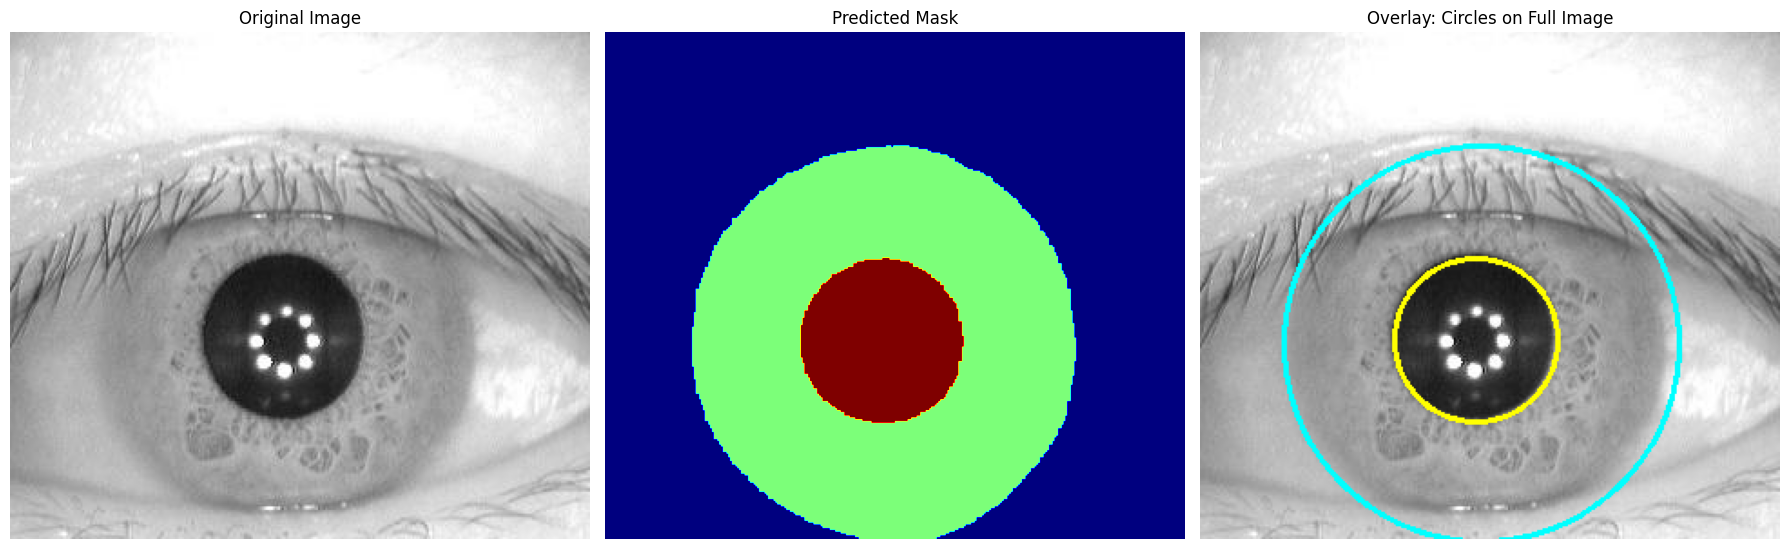

S1218L02.jpg
  Pupil (center, radius): ((152, 170), 45)
  Iris  (center, radius): ((155, 172), 109)


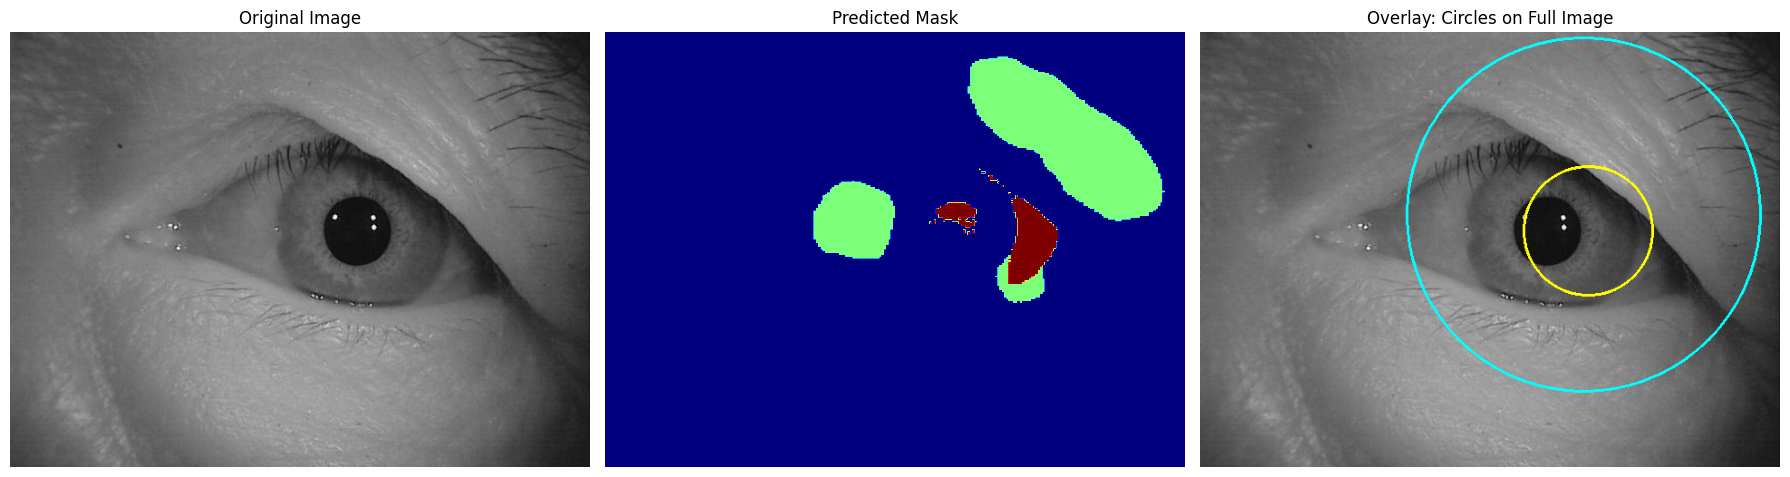

S2353L15.jpg
  Pupil (center, radius): ((428, 219), 71)
  Iris  (center, radius): ((423, 201), 195)


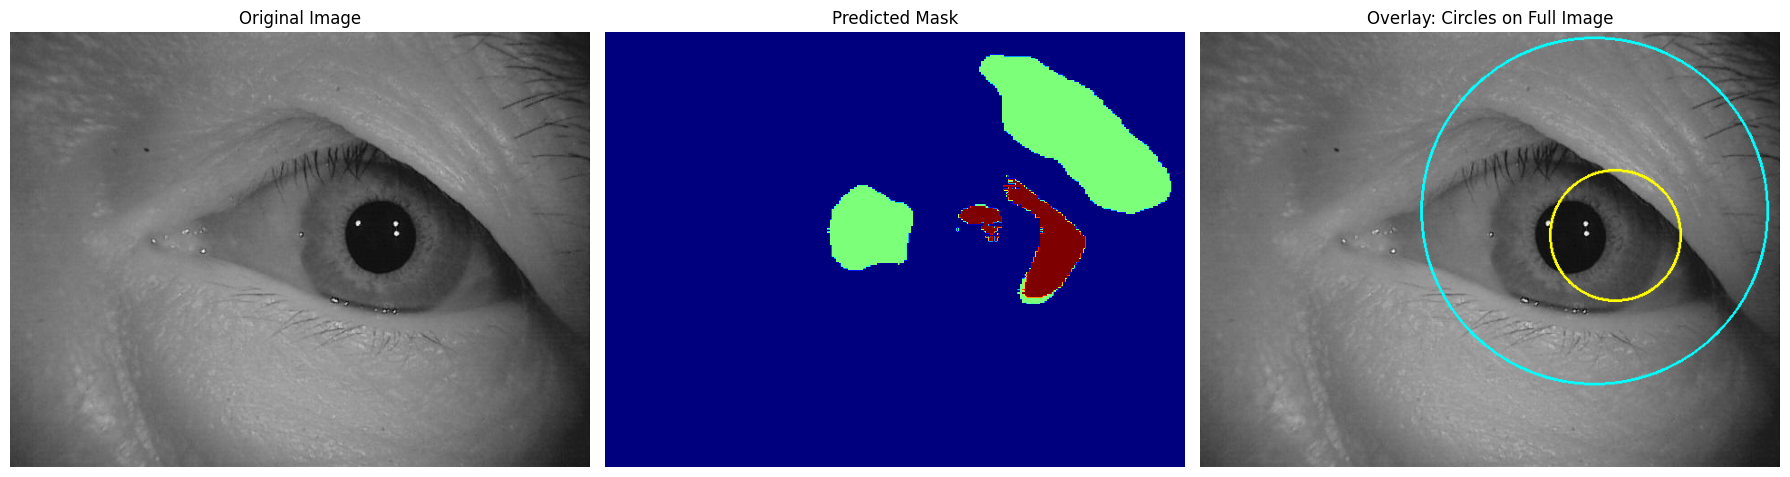

S2353L16.jpg
  Pupil (center, radius): ((458, 224), 72)
  Iris  (center, radius): ((435, 197), 191)


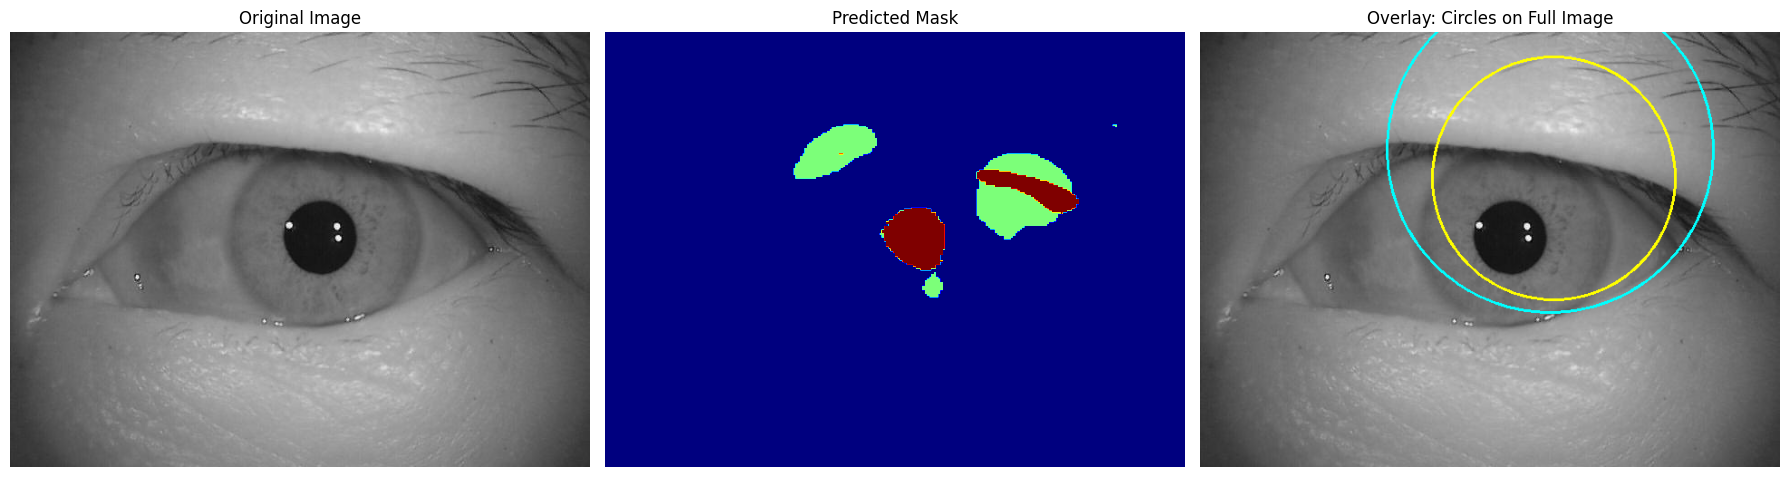

S2407L12.jpg
  Pupil (center, radius): ((390, 161), 134)
  Iris  (center, radius): ((386, 129), 180)


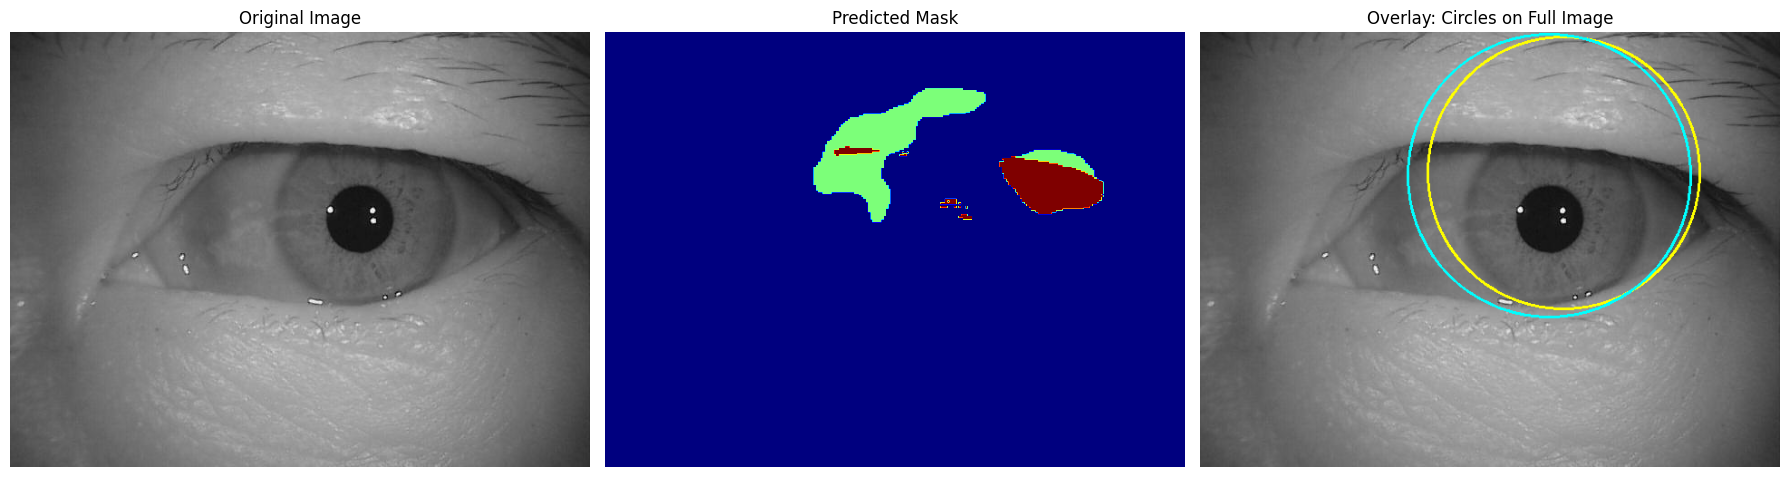

S2407L13.jpg
  Pupil (center, radius): ((401, 155), 150)
  Iris  (center, radius): ((385, 158), 156)


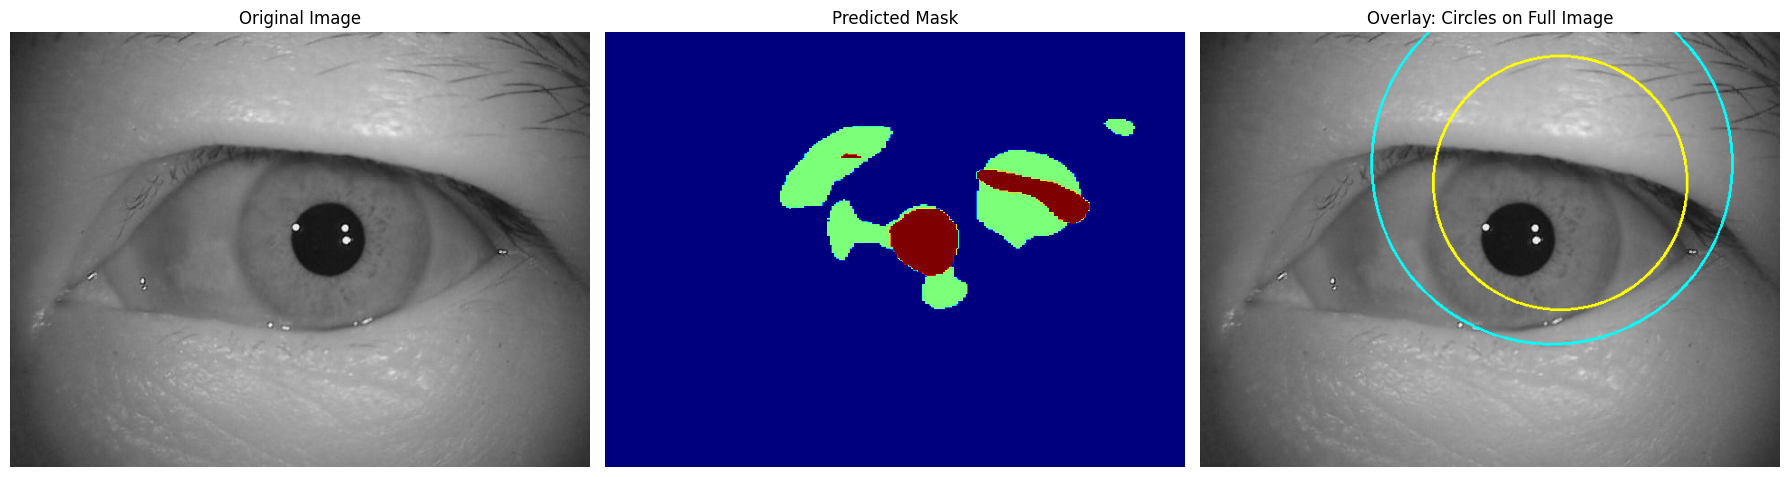

S2407L14.jpg
  Pupil (center, radius): ((397, 166), 140)
  Iris  (center, radius): ((388, 145), 199)


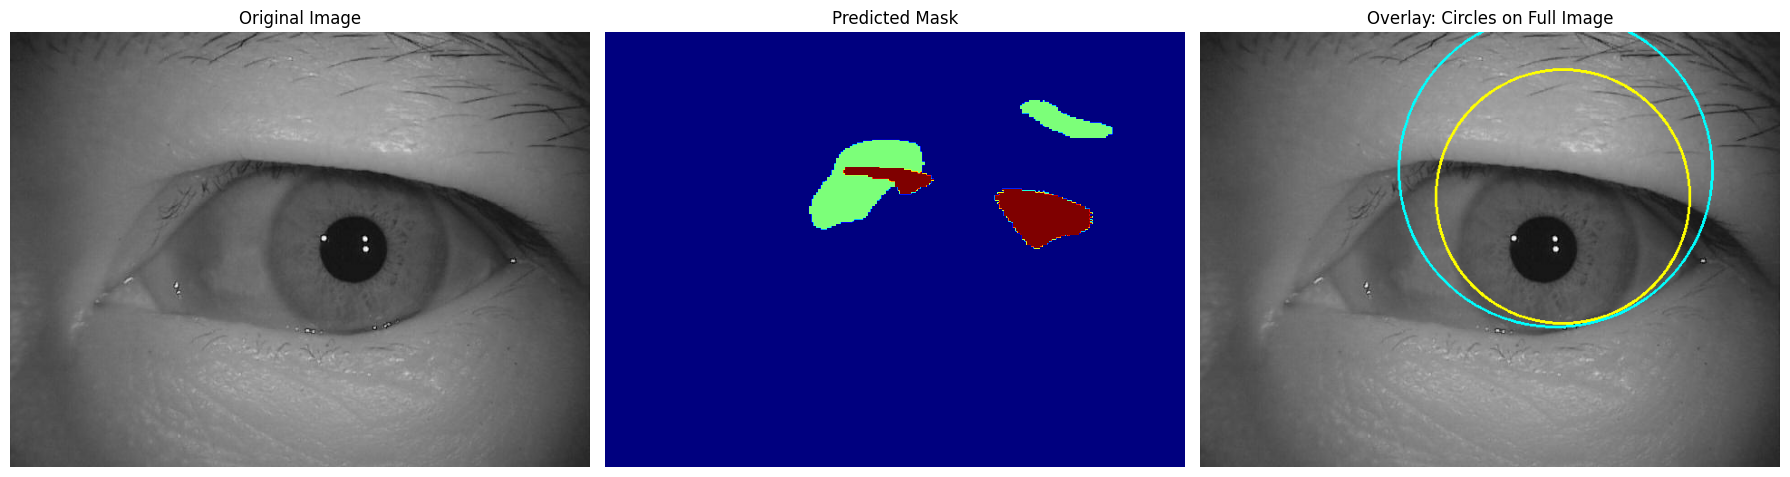

S2407L15.jpg
  Pupil (center, radius): ((400, 181), 140)
  Iris  (center, radius): ((392, 152), 173)


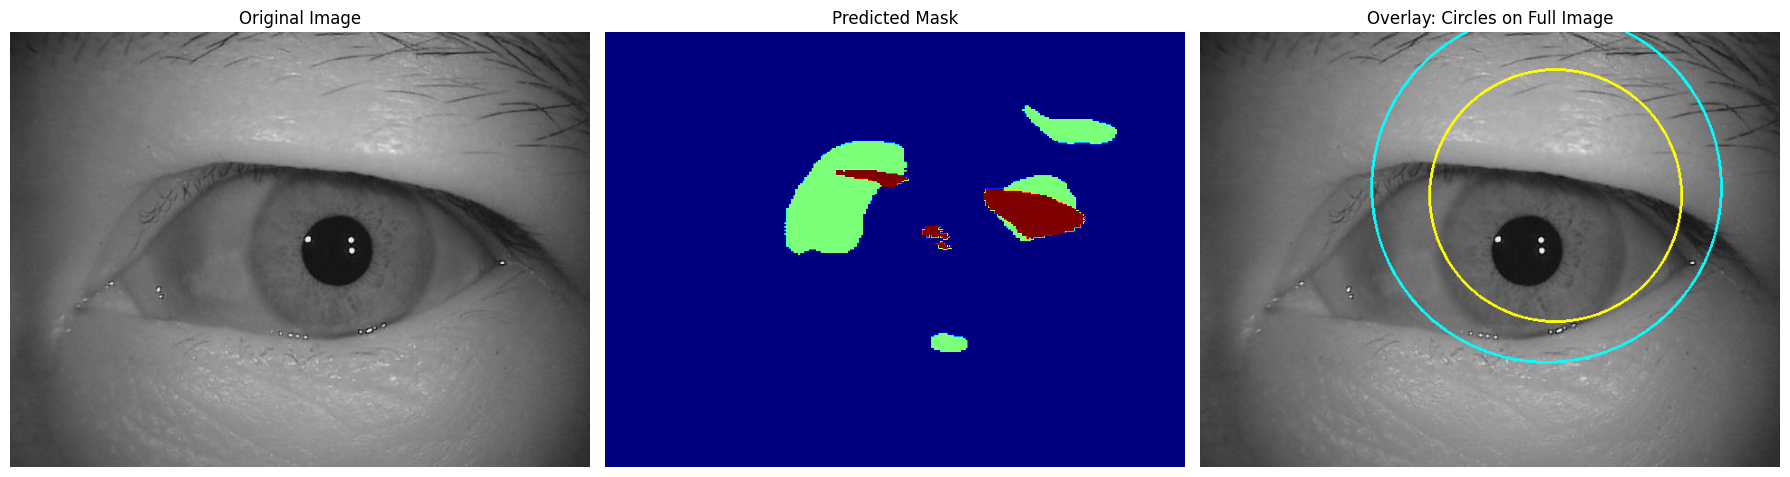

S2407L16.jpg
  Pupil (center, radius): ((392, 180), 139)
  Iris  (center, radius): ((382, 171), 193)


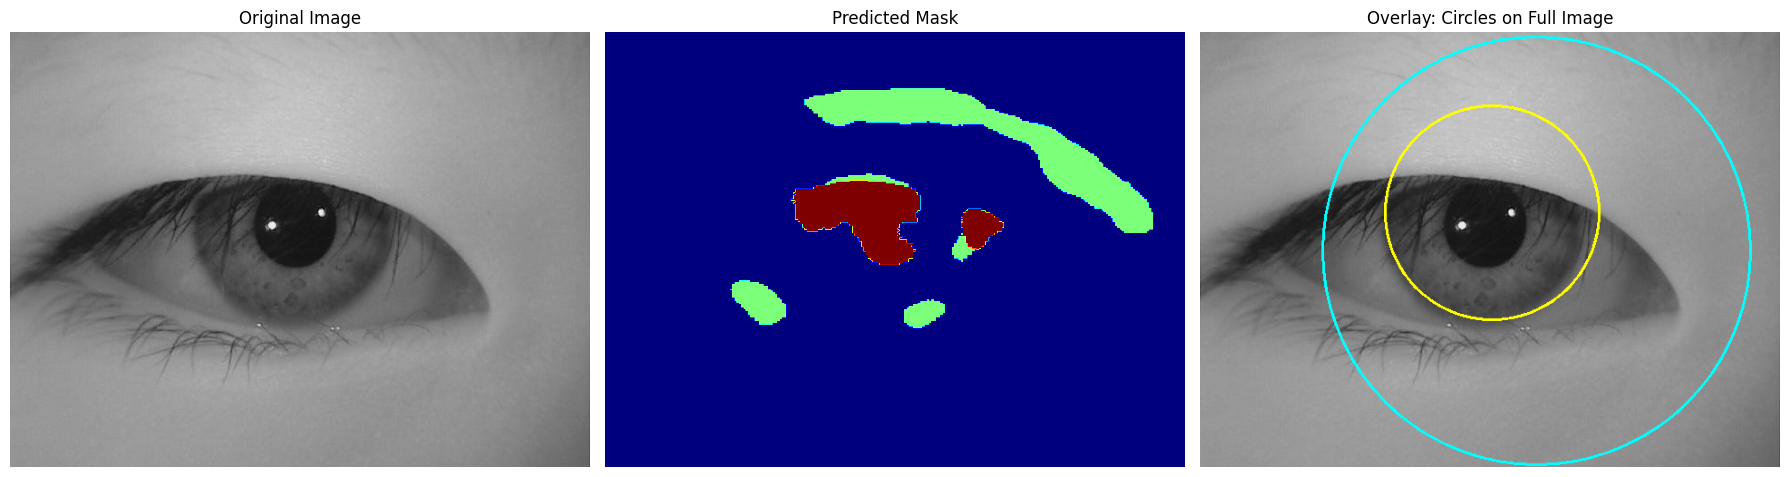

S3951L01.jpg
  Pupil (center, radius): ((322, 199), 118)
  Iris  (center, radius): ((371, 241), 236)


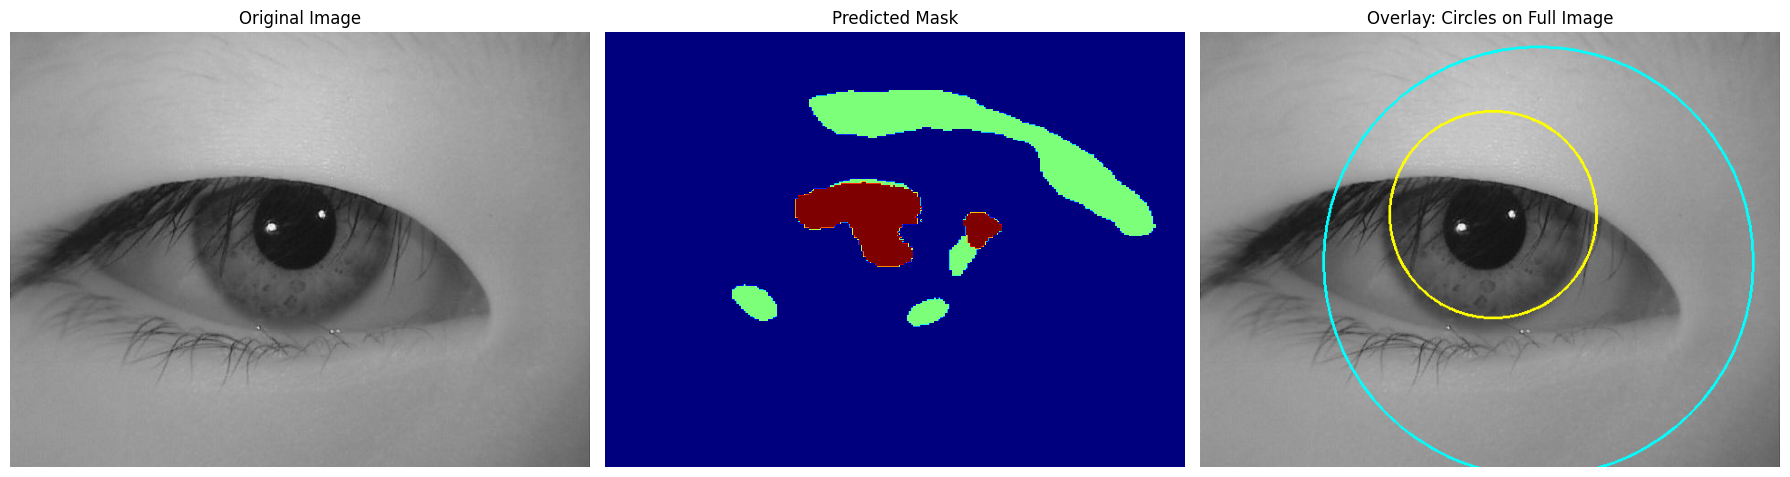

S3951L02.jpg
  Pupil (center, radius): ((323, 201), 114)
  Iris  (center, radius): ((373, 253), 237)


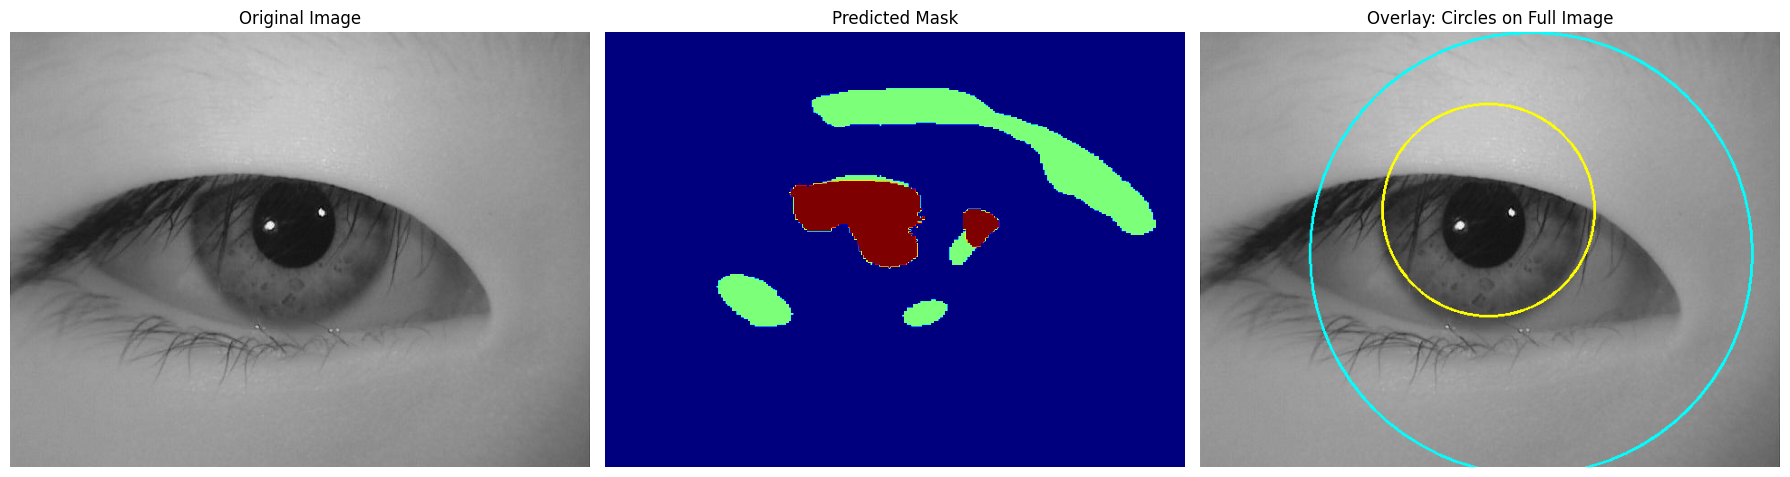

S3951L03.jpg
  Pupil (center, radius): ((318, 196), 117)
  Iris  (center, radius): ((365, 244), 244)


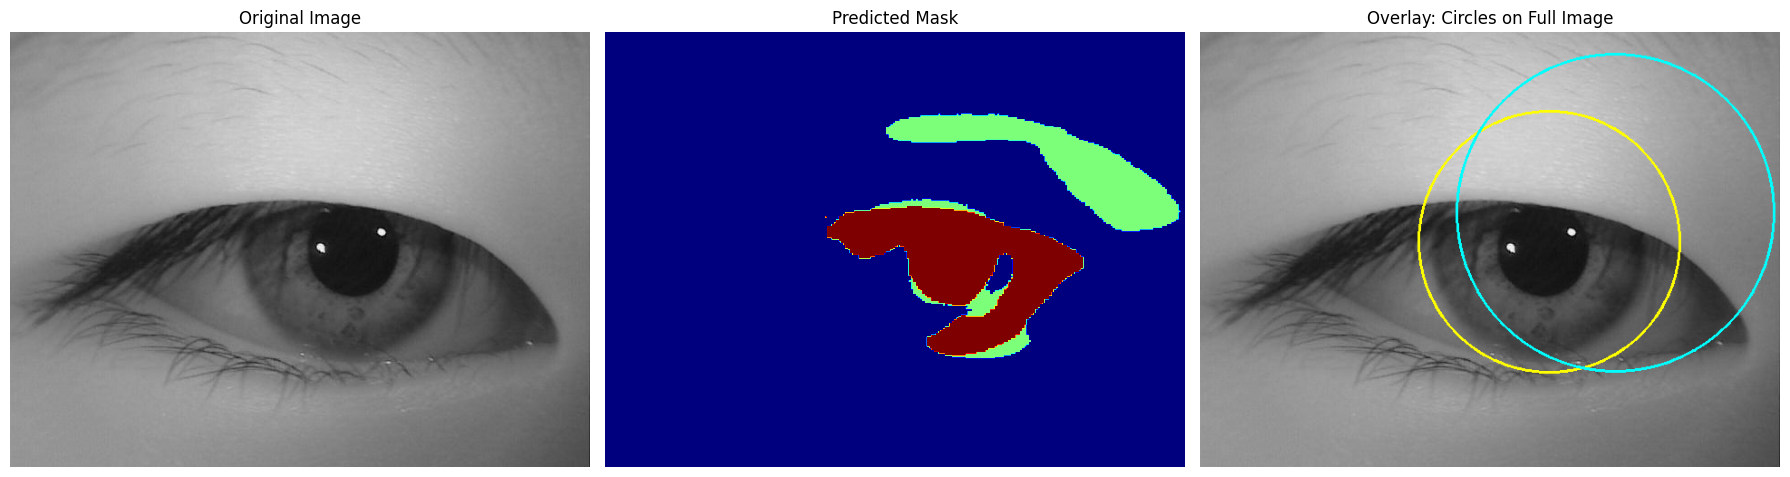

S3951L09.jpg
  Pupil (center, radius): ((385, 231), 144)
  Iris  (center, radius): ((458, 199), 175)


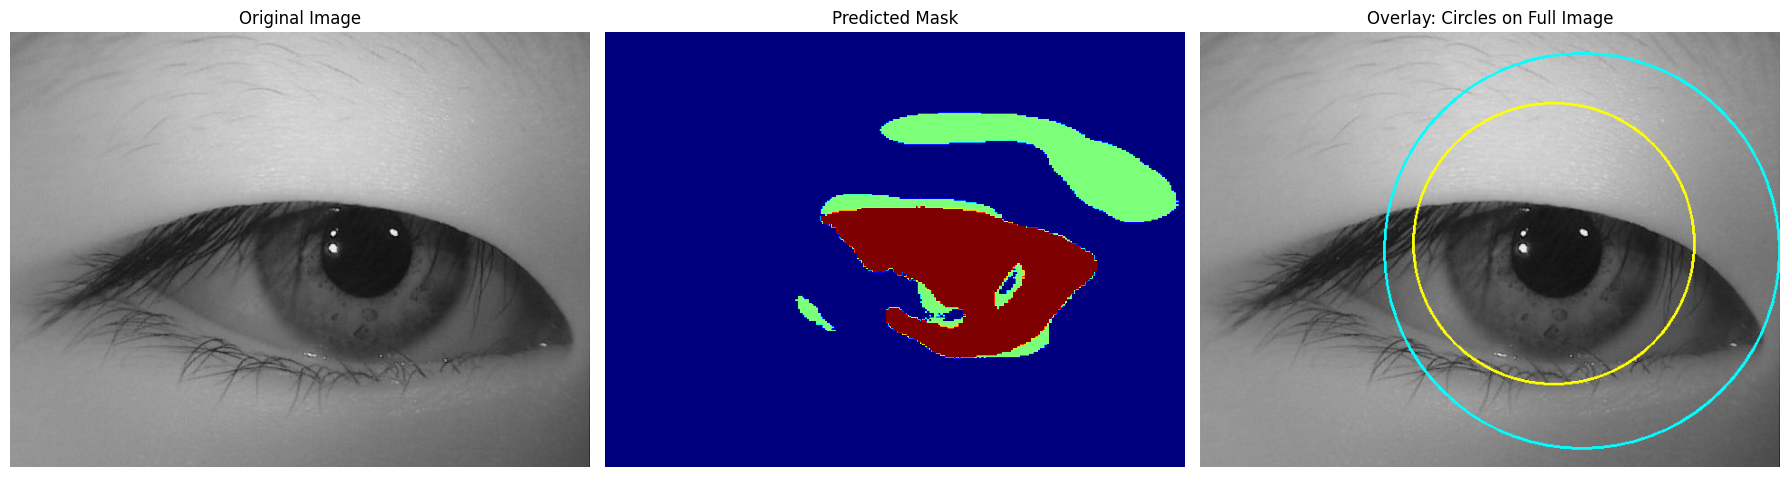

S3951L10.jpg
  Pupil (center, radius): ((390, 233), 155)
  Iris  (center, radius): ((421, 241), 218)


In [11]:
import os

image_folder = "images"  # folder with eye images
results = []

for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.jpg', '.png', '.bmp')):
        image_path = os.path.join(image_folder, filename)
        pupil, iris = segment_and_draw_circles(model, image_path)
        print(f"{filename}")
        print("  Pupil (center, radius):", pupil)
        print("  Iris  (center, radius):", iris)
        results.append({
            "filename": filename,
            "pupil": pupil,
            "iris": iris
        })


In [5]:
import zipfile

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("images/")


BadZipFile: File is not a zip file